<a href="https://colab.research.google.com/github/benbaz-2/comp551/blob/Aziz/Untitled3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import itertools
np.random.seed(42)

Text(0, 0.5, 'y')

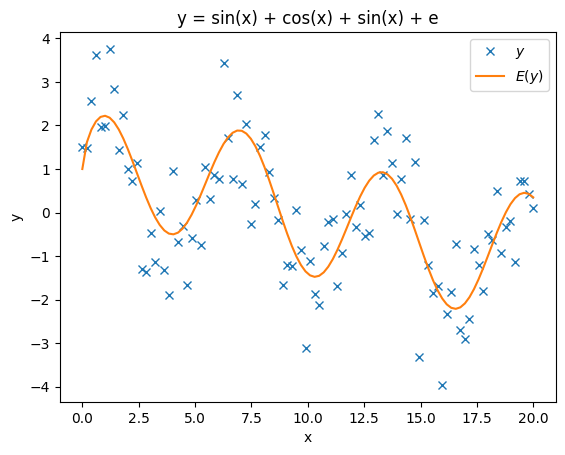

In [2]:
# generate data
N = 100   # sample size
f = lambda x: np.sin(np.sqrt(x)) + np.cos(x) + np.sin(x)

def generate_data(n):
  x = np.linspace(0, 20, n)
  e = np.random.normal(0, 1, n)
  y = f(x) + e
  return x, y

x, y = generate_data(N)

# plot data
plt.plot(x, y, 'x', label='$y$')
plt.plot(x, f(x), label='$E(y)$')
plt.legend()

plt.title('y = sin(x) + cos(x) + sin(x) + e')
plt.xlabel('x')
plt.ylabel('y')

Text(0.5, 0.98, 'Gaussian basis functions')

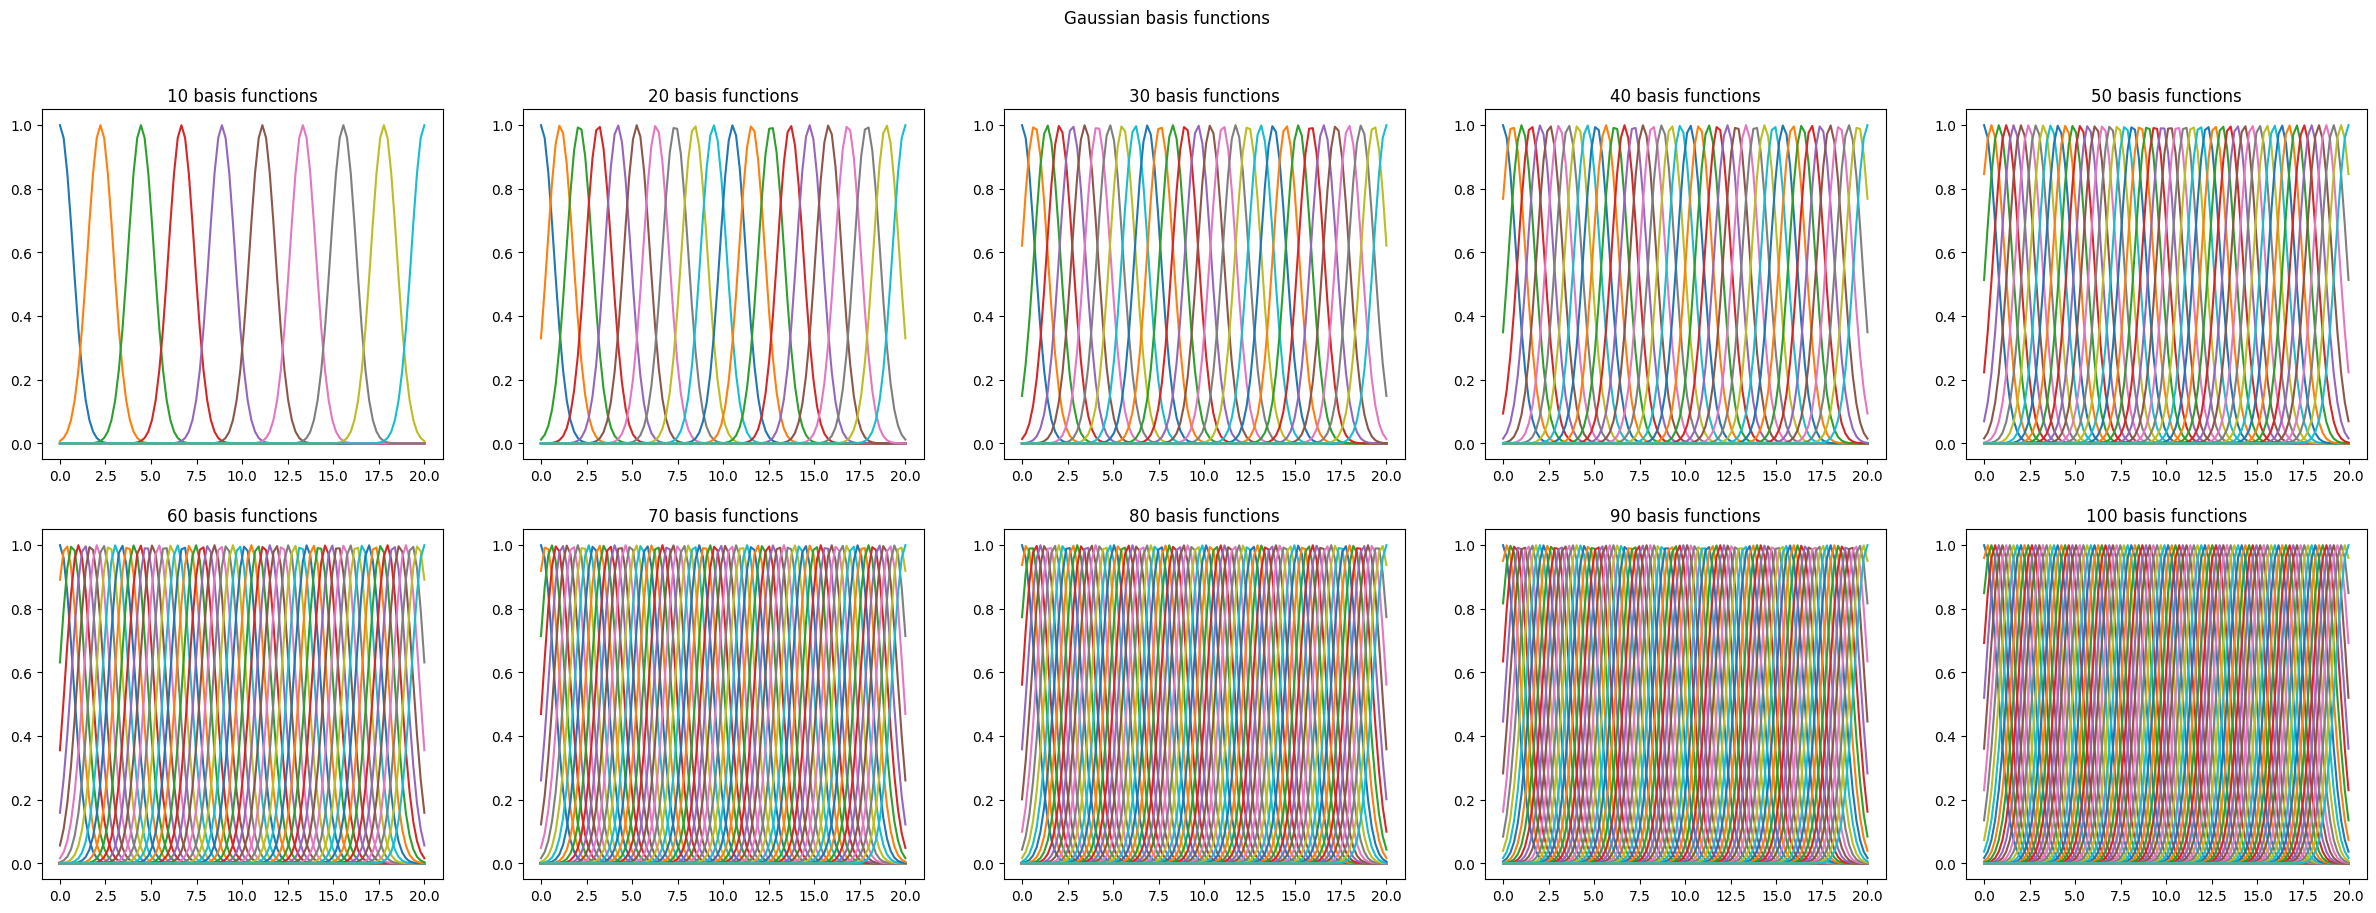

In [3]:
# plot gaussian basis functions
gaussian = lambda x, mu: np.exp(-(x-mu)**2)

fig, ax = plt.subplots(2, 5, figsize=(30, 10))
ax = ax.flatten()

num_bases = [0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100]

for i, n in enumerate(num_bases[1:]):
  mus = np.linspace(0, 20, n)
  ax[i].set_title(f'{n} basis functions')
  for mu in mus:
    ax[i].plot(x, gaussian(x, mu))

fig.suptitle('Gaussian basis functions')

In [4]:
# Implementation of the gaussian regression model
class GaussianRegression:
  def __init__(self, D, add_bias=True):
    self.add_bias = add_bias
    self.d = D                                        # b is the number of gaussian bases used
    self.w = None

  # This method creates the design matrix X
  def gaussian_bases(self, x):
    X = np.ones((len(x), self.d))
    mus = np.linspace(0, 20, self.d)
    for i, mu in enumerate(mus):
      X[:, i] = gaussian(x, mu)
    return X

  def fit(self, x, y):
    X = self.gaussian_bases(x)                      # Generate the design matrix
    if y.ndim == 1:
      y = y.reshape(-1, 1)
    if self.add_bias:
      X = np.hstack((np.ones((X.shape[0], 1)), X))
    self.w = np.linalg.pinv(X.T @ X) @ X.T @ y
    return self

  def predict(self, x):
    X = self.gaussian_bases(x)
    if self.add_bias:
      X = np.hstack((np.ones((X.shape[0], 1)), X))
    return X @ self.w

  def sse(self, x, y):
    if y.ndim == 1:
      y = y.reshape(-1, 1)
    return np.sum((y - self.predict(x))**2)                       # Return the sum of squared error

  def mse(self, x, y):
    if y.ndim == 1:
      y = y.reshape(-1, 1)
    return np.mean((y - self.predict(x))**2)

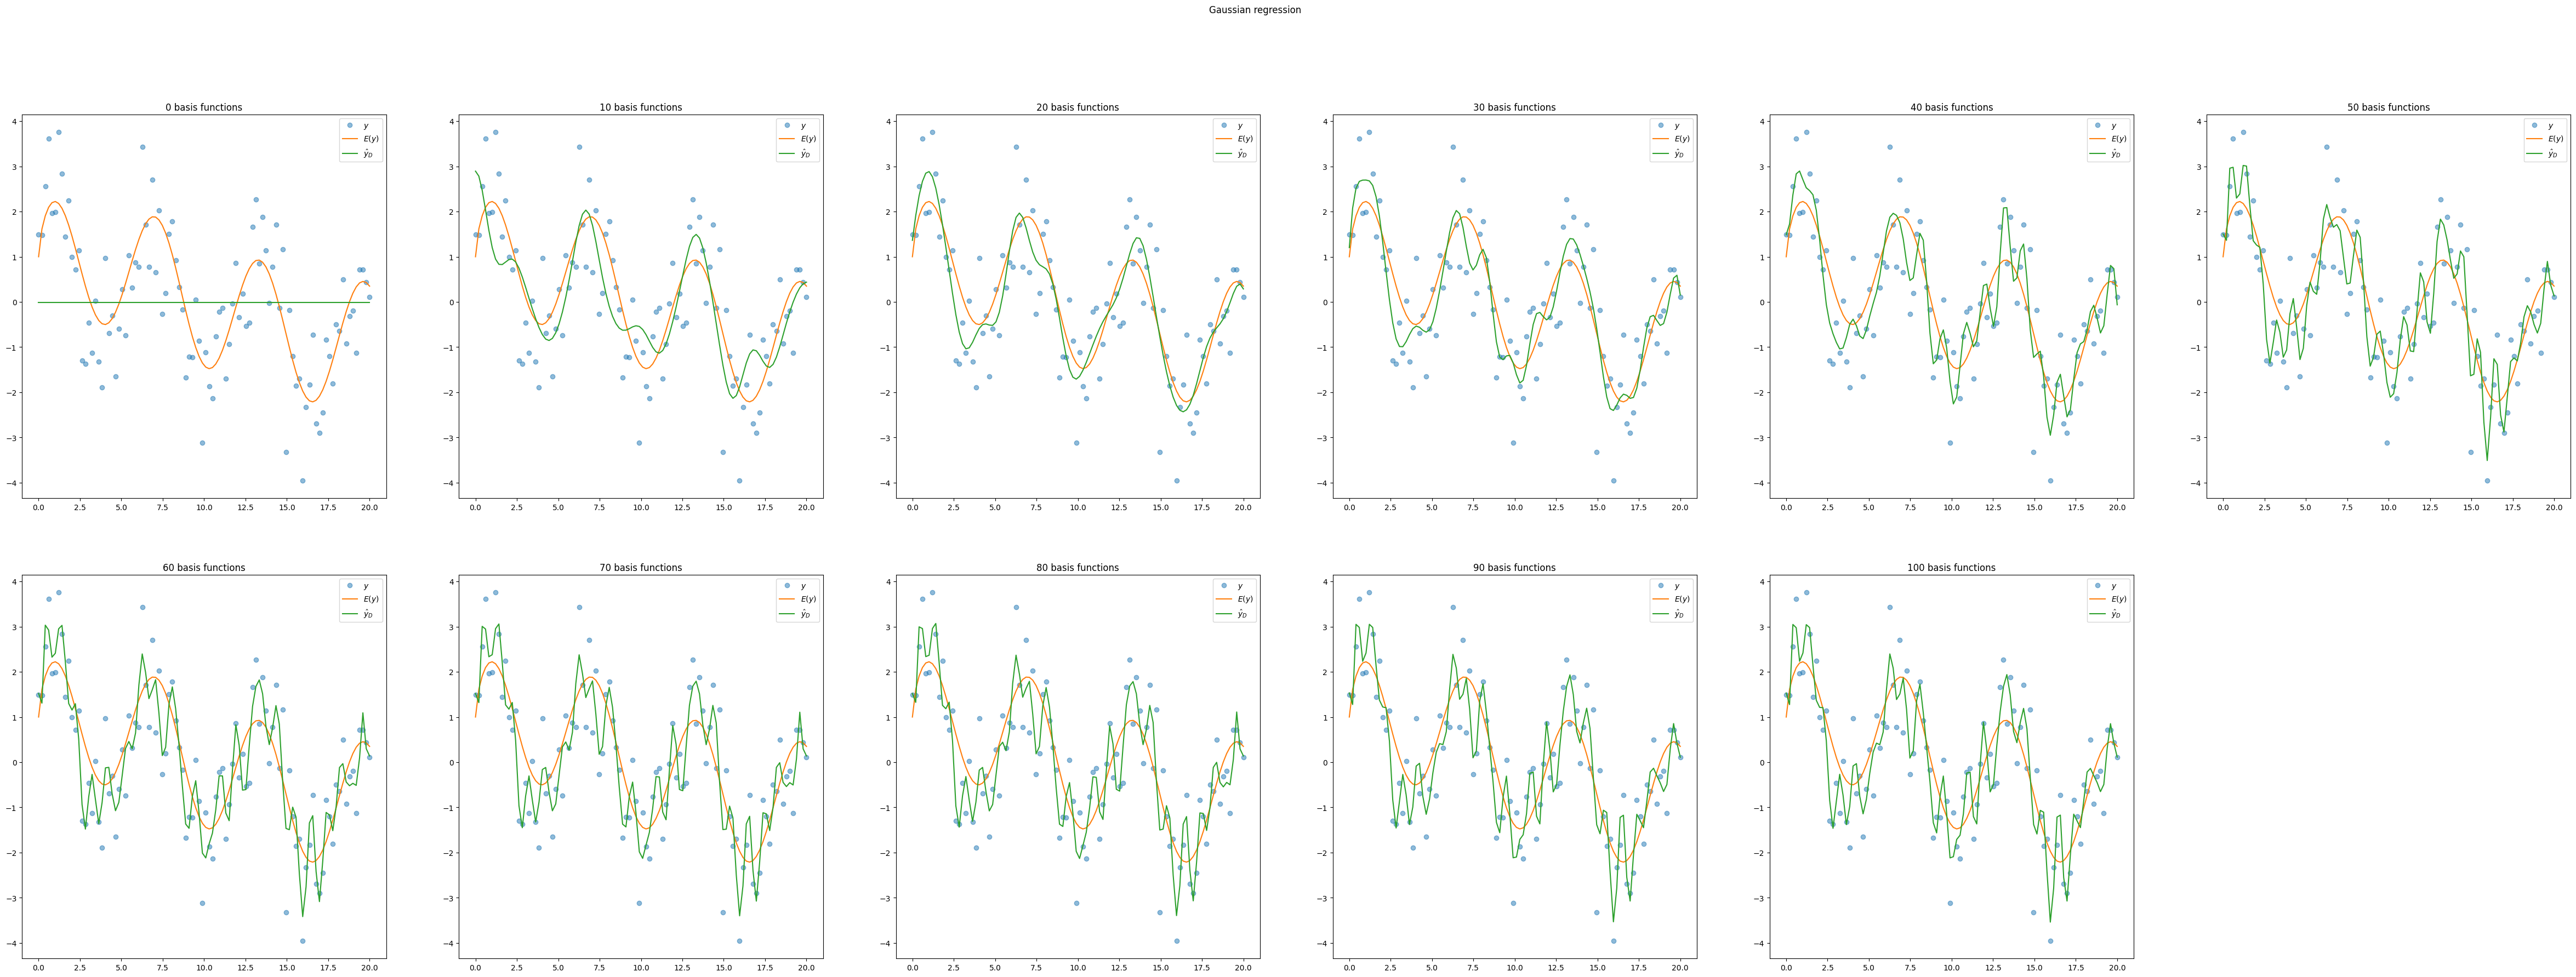

In [5]:
# plotting predictions for models with different number of basis functions
fig, ax = plt.subplots(2, 6, figsize=(60, 20))
ax = ax.flatten()

for i, n in enumerate(num_bases):
  model = GaussianRegression(n)
  model.fit(x, y)
  yh = model.predict(x)

  ax[i].set_title(f'{n} basis functions')
  ax[i].plot(x, y, 'o', label='$y$', alpha=0.5)
  ax[i].plot(x, f(x), label='$E(y)$')
  ax[i].plot(x, yh, label='$\hat{y}_D$')
  ax[i].legend()

fig.suptitle('Gaussian regression')

ax[11].set_visible(False)

Text(0, 0.5, 'Error')

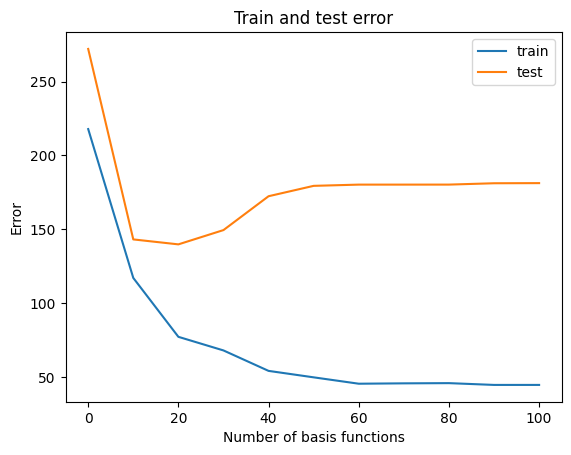

In [6]:
# calculating train and test error

# note, the error is way larger when sampling using np.random.uniform, rather than linspace

x_train, y_train = generate_data(N)
x_test, y_test = generate_data(N)

train_errors = np.zeros(len(num_bases))
test_errors = np.zeros(len(num_bases))

for n in num_bases:
  model = GaussianRegression(n)
  model.fit(x, y_train)
  train_errors[n] = model.sse(x_train, y_train)
  test_errors[n] = model.sse(x_test, y_test)

plt.plot(num_bases, train_errors, label='train')
plt.plot(num_bases, test_errors, label='test')
plt.legend()
plt.title('Train and test error')
plt.xlabel('Number of basis functions')
plt.ylabel('Error')


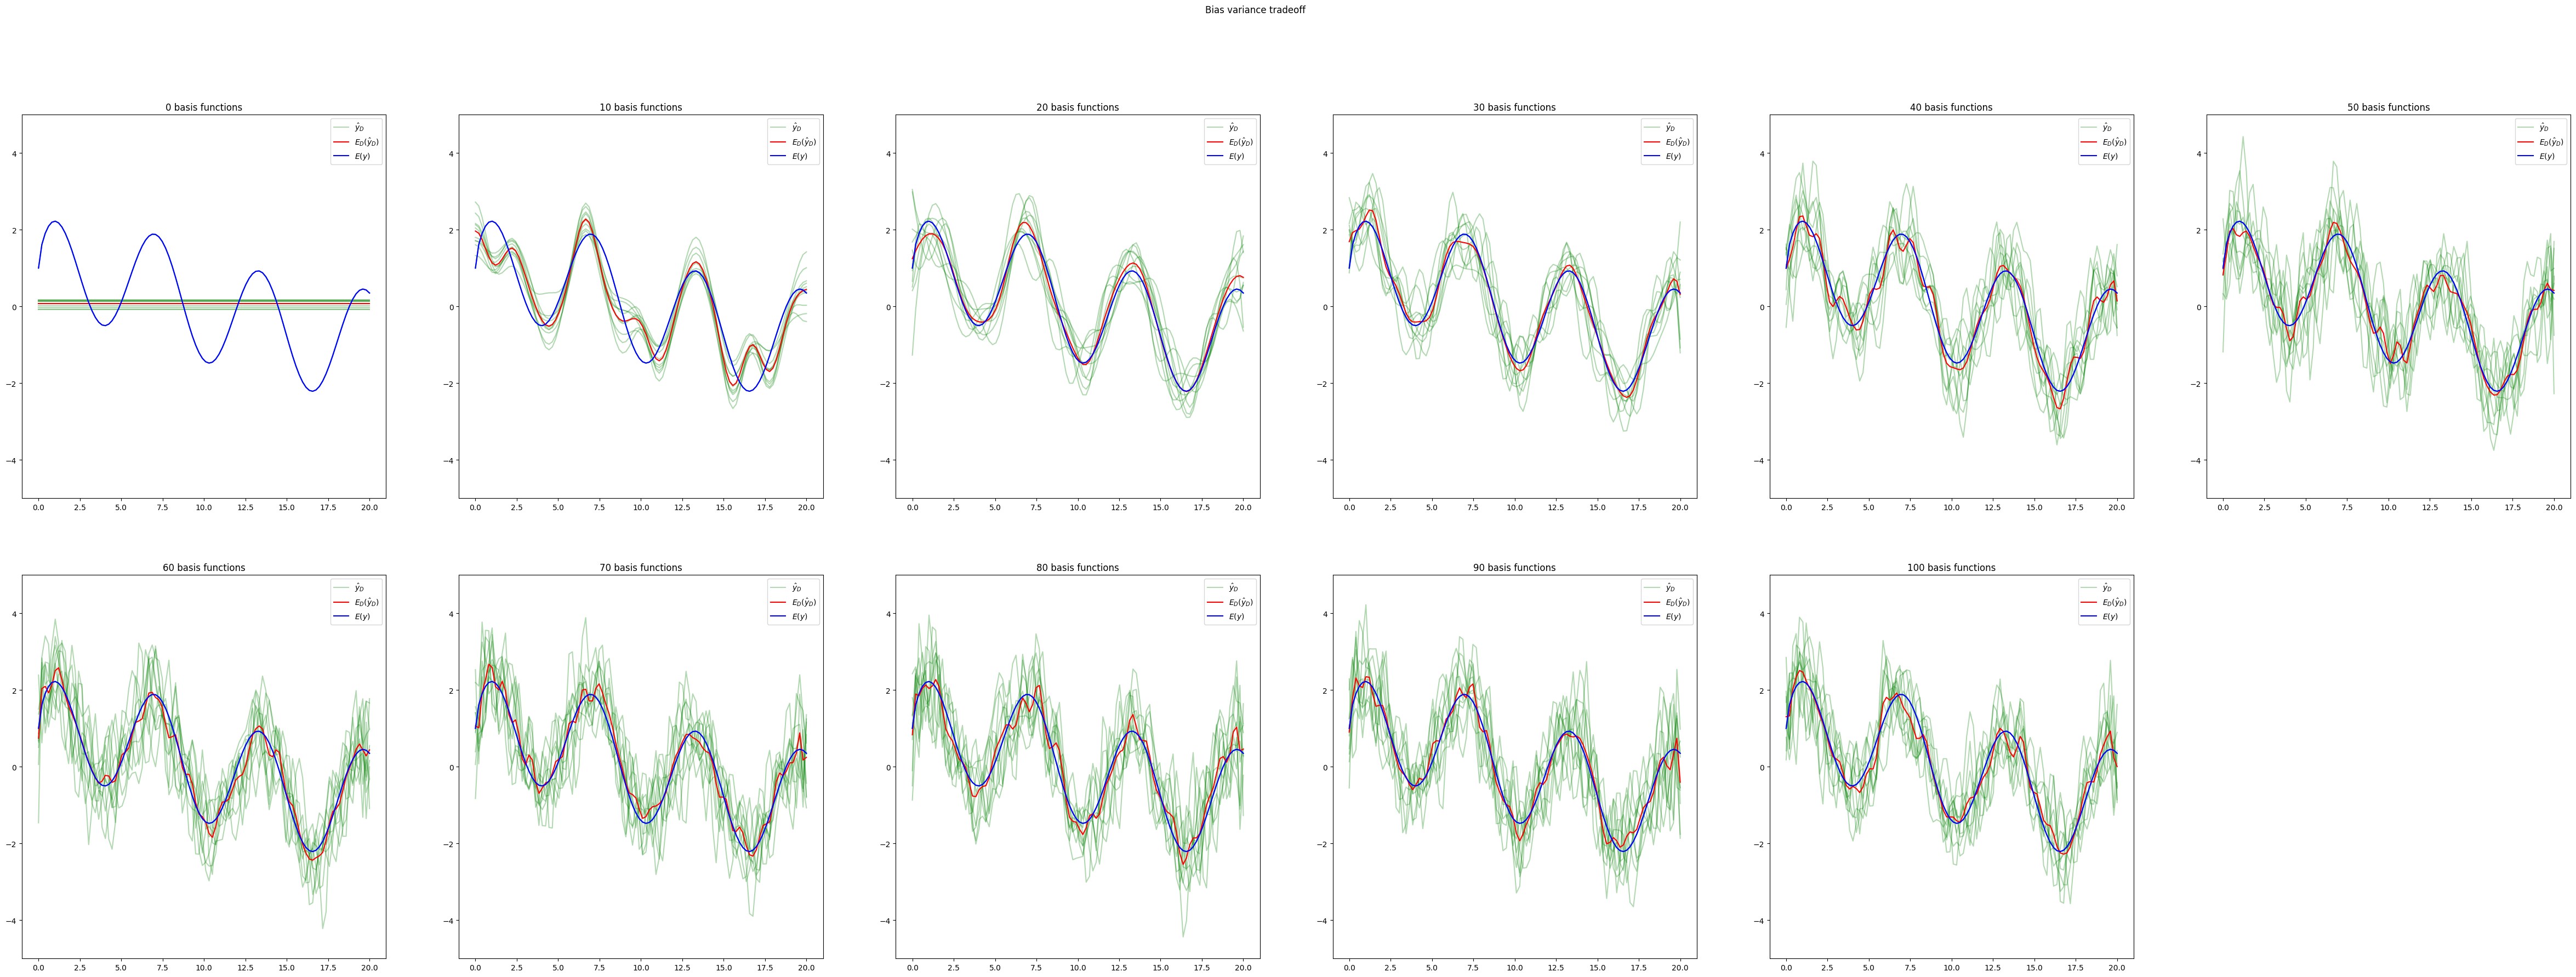

In [11]:
# bias variance tradeoff

num_repetitions = 10

fig, ax = plt.subplots(2, 6, figsize=(60, 20))
ax = ax.flatten()

for i, n in enumerate(num_bases):
  predictions = np.zeros((N, num_repetitions))

  for j in range(num_repetitions):
    x_train, y_train = generate_data(N)
    x_test, y_test = generate_data(N)
    model = GaussianRegression(n)
    model.fit(x_train, y_train)
    yh = model.predict(x_test)
    predictions[:, j] = yh.flatten()
    ax[i].plot(x_test, yh, alpha=0.3, color='green', label='$\hat{y}_D$' if j == 0 else '')

  ax[i].set_title(f'{n} basis functions')
  ax[i].plot(x, f(x))
  mean_predictions = np.mean(predictions, axis=1)
  ax[i].plot(x, mean_predictions, color='red', label='$E_D(\hat{y}_D)$')
  ax[i].plot(x, f(x), label='$E(y)$', color='blue')
  ax[i].set_ylim(-5, 5)
  ax[i].legend()

fig.suptitle('Bias variance tradeoff')
ax[11].set_visible(False)

Text(0, 0.5, 'Error')

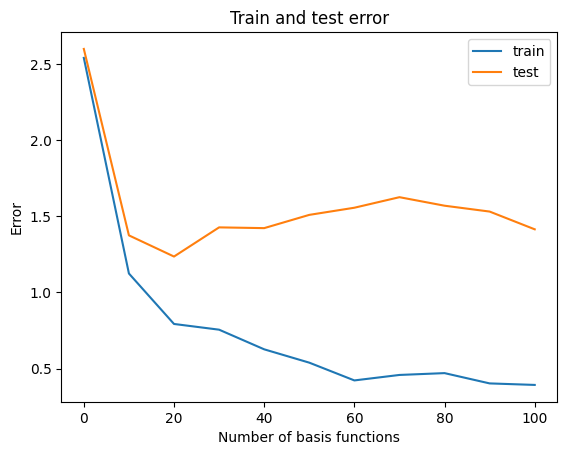

In [15]:
train_errors = np.zeros((num_repetitions, len(num_bases)))
test_errors = np.zeros((num_repetitions, len(num_bases)))

for i, n in enumerate(num_bases):
  for j in range(num_repetitions):
    x_train, y_train = generate_data(N)
    x_test, y_test = generate_data(N)
    model = GaussianRegression(n)
    model.fit(x_train, y_train)

    train_errors[j, i] = model.mse(x_train, y_train)
    test_errors[j, i] = model.mse(x_test, y_test)

mean_train_errors = np.mean(train_errors, axis=0)
mean_test_errors = np.mean(test_errors, axis=0)

plt.plot(num_bases, mean_train_errors, label='train')
plt.plot(num_bases, mean_test_errors, label='test')
plt.legend()
plt.title('Train and test error')
plt.xlabel('Number of basis functions')
plt.ylabel('Error')


In [ ]:
# Implementation of the gaussian regression model with lasso and ridge
class GaussianRegression:
  def __init__(self, D, add_bias=True, epsilon=5e-2, alpha=1e-3, lambdaa=1e-2, max_iter=1e5, lasso=False, ridge=False):
    self.add_bias = add_bias
    self.b = D                                        # b is the number of gaussian bases used
    self.epsilon = epsilon
    self.alpha = alpha
    self.lambdaa = lambdaa
    self.max_iter = max_iter
    self.w = None
    self.lasso = lasso
    self.ridge = ridge

  # This method creates the design matrix X
  def gaussian_bases(self, x):
    X = np.zeros((len(x), self.b))
    mus = np.linspace(0, 20, self.b)
    for i, mu in enumerate(mus):
      X[:, i] = gaussian(x, mu)
    return X

  def fit(self, x, y):
    X = self.gaussian_bases(x)                     # Generate the design matrix

    if y.ndim == 1:
      y = y.reshape(-1, 1)
    if self.add_bias:
      X = np.hstack((np.ones((X.shape[0], 1)), X))

    if self.lasso:
      self.w = self.lasso_fit(X, y)
      return self

    elif self.ridge:
      I = np.eye(X.shape[1])
      self.w = np.linalg.pinv(X.T @ X + self.lambdaa * I) @ X.T @ y
      return self

    else:
      self.w = np.linalg.pinv(X.T @ X) @ X.T @ y
      return self

  def lasso_fit(self, X, y):
    w = np.zeros((X.shape[1], 1))
    e = np.inf
    i = 0
    while e > self.epsilon and i < self.max_iter:
      N, D = X.shape
      gradient = 1/N * X.T @ (X @ w - y) + self.lambdaa * np.sign(w)
      w = w - self.alpha * gradient
      e = np.linalg.norm(gradient)
      i += 1
    return w

  def predict(self, x):
    X = self.gaussian_bases(x)
    if self.add_bias:
      X = np.hstack((np.ones((X.shape[0], 1)), X))
    return X @ self.w

  def sse(self, x, y):
    if y.ndim == 1:
      y = y.reshape(-1, 1)
    return np.sum((y - self.predict(x))**2)                       # Return the sum of squared error

  def mse(self, x, y):
    if y.ndim == 1:
      y = y.reshape(-1, 1)
    return np.mean((y - self.predict(x))**2)

In [ ]:
lambdaas = np.logspace(-4, 2, 15)
N = 20
D = 70
num_datasets = 50

# iterate over many datasets
for i in range(num_datasets):
  x_train = np.linspace(0, 20, N)
  np.random.shuffle(x_train)
  epsilon = np.random.normal(0, 1, N)
  y_train = f(x_train) + epsilon

  # iterate over different values of lambda
  for j, k in enumerate(lambdaas):

    # iterate over different folds
    for i in range(10):
      test_fold = x_train



In [ ]:
lambdaas = np.logspace(-4, 2, 15)
N = 100
D = 70

x = np.linspace(0, 20, N)
np.random.shuffle(x)
epsilon = np.random.normal(0, 1, N)
y = f(x) + epsilon

ridge_train_errors = []
ridge_test_errors = []

lasso_train_errors = []
lasso_test_errors = []

# Ridge regression regularization
for lambdaa in lambdaas:
  test_error = 0
  train_error = 0
  for n in range(10):
    x_train = x[n * 10: (n+1) * 10 - 1]
    y_train = y[n * 10: (n+1) * 10 - 1]
    x_test = np.concatenate((x[: n * 10], x[(n+1) * 10:]))
    y_test = np.concatenate((y[: n * 10], y[(n+1) * 10:]))
    model = GaussianRegression(D, lambdaa=lambdaa, ridge=True)
    model.fit(x_train, y_train)
    test_error += model.mse(x_test, y_test)
    train_error += model.mse(x_train, y_train)

  ridge_train_errors.append(train_error / 10)
  ridge_test_errors.append(test_error / 10)

# Lasso regression regularization
for lambdaa in lambdaas:
  test_error = 0
  train_error = 0
  for n in range(10):
    x_train = x[n * 10: (n+1) * 10 - 1]
    y_train = y[n * 10: (n+1) * 10 - 1]
    x_test = np.concatenate((x[: n * 10], x[(n+1) * 10:]))
    y_test = np.concatenate((y[: n * 10], y[(n+1) * 10:]))
    model = GaussianRegression(D, lambdaa=lambdaa, lasso=True, max_iter=1e4)
    model.fit(x_train, y_train)
    test_error += model.mse(x_test, y_test)
    train_error += model.mse(x_train, y_train)

  lasso_train_errors.append(train_error / 10)
  lasso_test_errors.append(test_error / 10)